In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi
!pip install -q torchvision tqdm scikit-learn matplotlib Pillow

Mounted at /content/drive
Wed Aug  6 06:52:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

In [ ]:
import os
from pathlib import Path

project_root = Path("/content/drive/MyDrive/chest_project")
data_dir = project_root / "chest_xray" / "chest_xray"

train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"

In [ ]:
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# 전체 train 폴더의 이미지 경로와 라벨 수집
image_paths = []
labels = []

class_to_idx = {"NORMAL": 0, "PNEUMONIA": 1}

for class_name in os.listdir(train_dir):
    class_path = train_dir / class_name
    if not class_path.is_dir():
        continue
    for fname in os.listdir(class_path):
        if fname.endswith(".jpeg") or fname.endswith(".jpg") or fname.endswith(".png"):
            image_paths.append(class_path / fname)
            labels.append(class_to_idx[class_name])

# Stratified Split (8:2)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Custom Dataset 정의
class ChestDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Dataset 구성
train_dataset = ChestDataset(train_paths, train_labels, transform=transform)
val_dataset   = ChestDataset(val_paths, val_labels, transform=transform)

# DataLoader 구성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pretrained ResNet34 불러오기
"""
ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
  (bn1): BatchNorm2d(64)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1)
  (layer1): Sequential( ... 3개의 BasicBlock ... )
  (layer2): Sequential( ... 4개의 BasicBlock ... )
  (layer3): Sequential( ... 6개의 BasicBlock ... )
  (layer4): Sequential( ... 3개의 BasicBlock ... )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=2, bias=True)  <-- 수정됨
)
"""
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 170MB/s]


In [ ]:
from torch.optim.lr_scheduler import CyclicLR

# 옵티마이저와 스케줄러 설정
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = CyclicLR(
    optimizer,
    base_lr=1e-5,
    max_lr=1e-3,
    step_size_up=len(train_loader) * 2,  # 2 에포크 기준
    mode="triangular",
    cycle_momentum=False  # Adam 사용 시 꼭 False로!
)

num_epochs = 5
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # 🔁 CyclicLR 스케줄러 업데이트

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_accuracies.append(train_acc)

    # 검증
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), project_root / "best_resnet34_addval.pth")
        print(f">> Best model saved at epoch {epoch+1} with val_acc = {val_acc:.4f}")

100%|██████████| 131/131 [36:47<00:00, 16.85s/it]


[Epoch 1] Train Acc: 0.9276 | Val Acc: 0.9626
>> Best model saved at epoch 1 with val_acc = 0.9626


100%|██████████| 131/131 [01:39<00:00,  1.32it/s]


[Epoch 2] Train Acc: 0.9667 | Val Acc: 0.9559


100%|██████████| 131/131 [01:39<00:00,  1.31it/s]


[Epoch 3] Train Acc: 0.9815 | Val Acc: 0.9837
>> Best model saved at epoch 3 with val_acc = 0.9837


100%|██████████| 131/131 [01:41<00:00,  1.29it/s]


[Epoch 4] Train Acc: 0.9930 | Val Acc: 0.9923
>> Best model saved at epoch 4 with val_acc = 0.9923


100%|██████████| 131/131 [01:41<00:00,  1.29it/s]


[Epoch 5] Train Acc: 0.9969 | Val Acc: 0.9818


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF

def generate_gradcam(model, image_tensor, target_class, device):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # 기존: model.layer4[1].conv2
    # 변경: 마지막 Conv Block 전체
    target_layer = model.layer4[-1]

    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_full_backward_hook(backward_hook)

    # # 마지막 conv layer 등록 (ResNet의 layer4[1].conv2가 마지막)
    # handle_fw = model.layer4[1].conv2.register_forward_hook(forward_hook)
    # handle_bw = model.layer4[1].conv2.register_full_backward_hook(backward_hook)

    image_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(image_tensor)

    model.zero_grad()
    loss = output[0, target_class]
    loss.backward()

    grads = gradients[0].detach().cpu().numpy()[0]
    acts = activations[0].detach().cpu().numpy()[0]
    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * acts[i]
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-5)
    cam = np.uint8(255 * cam)
    cam = np.stack([cam]*3, axis=2)
    cam = TF.to_pil_image(cam)
    cam = cam.resize((image_tensor.shape[2], image_tensor.shape[3]))

    handle_fw.remove()
    handle_bw.remove()
    return cam

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def show_gradcam_colored(image_tensor, cam, label=None, pred_class=None):
    # 1. 원본 이미지 복원
    image_np = image_tensor.permute(1, 2, 0).numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # 2. cam(PIL.Image)을 numpy로 변환
    cam_np = np.array(cam)

    # 3. 컬러 맵 적용
    heatmap = cv2.applyColorMap(cam_np, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 4. overlay
    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # 5. 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original (Label: {label})")
    plt.imshow(image_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM (Pred: {pred_class})")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

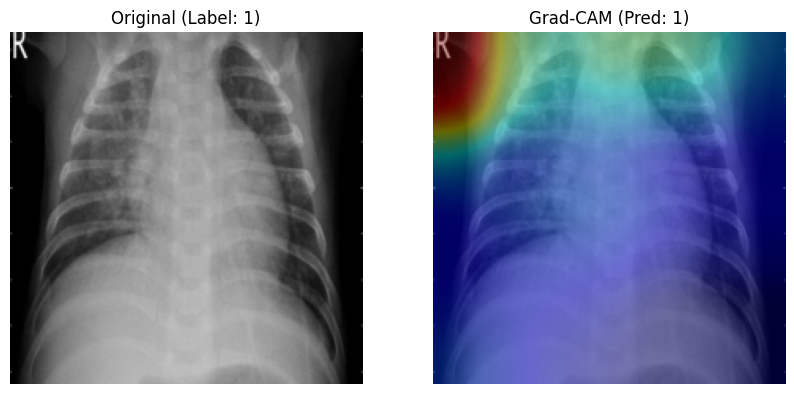

In [ ]:
import random
from torchvision.transforms.functional import to_pil_image

# 1. 검증 데이터셋에서 샘플 선택
sample_idx = random.randint(0, len(val_dataset) - 1)
image_tensor, label = val_dataset[sample_idx]

# 2. 예측 수행
model.eval()
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0).to(device))
    pred_class = output.argmax(1).item()

# 3. Grad-CAM 생성
cam = generate_gradcam(model, image_tensor, target_class=pred_class, device=device)

# 4. 컬러 시각화 함수 호출
show_gradcam_colored(image_tensor, cam, label=label, pred_class=pred_class)

In [ ]:
# print(image_tensor.max())
# print(image_tensor.min())

tensor(0.7647)
tensor(0.)


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_roc_and_confusion(model, dataloader, device):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            y_probs.extend(probs)
            y_true.extend(labels.numpy())

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    # ROC Curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    y_pred = [1 if p > 0.5 else 0 for p in y_probs]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

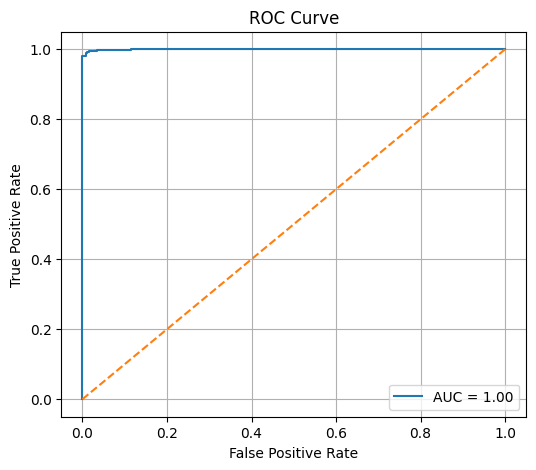

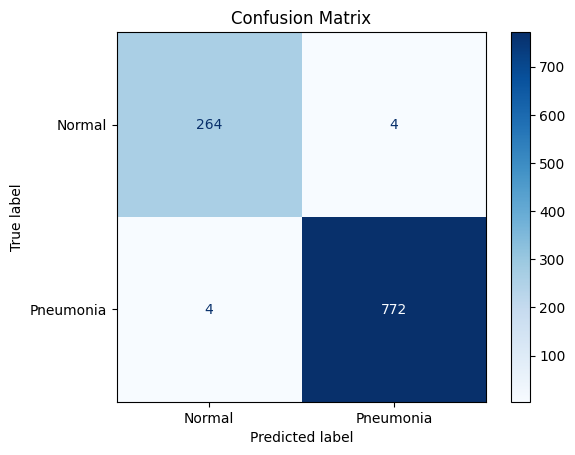

In [ ]:
plot_roc_and_confusion(model, val_loader, device)

In [ ]:
def predict_with_tta(model, image_tensor, device):
    model.eval()
    images = [image_tensor, TF.hflip(image_tensor)]
    preds = []

    with torch.no_grad():
        for img in images:
            img = img.unsqueeze(0).to(device)
            out = model(img)
            prob = torch.softmax(out, dim=1)
            preds.append(prob)
    return torch.mean(torch.stack(preds), dim=0)

def evaluate_tta_vs_base(model, dataloader, device):
    model.eval()
    base_correct, tta_correct = 0, 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            for i in range(len(images)):
                img, label = images[i], labels[i]

                base_output = model(img.unsqueeze(0).to(device))
                tta_output = predict_with_tta(model, img, device)

                base_pred = base_output.argmax(1).item()
                tta_pred = tta_output.argmax(1).item()

                base_correct += int(base_pred == label.item())
                tta_correct += int(tta_pred == label.item())
                total += 1

    print(f"Base Accuracy: {base_correct/total:.4f}")
    print(f"TTA Accuracy:  {tta_correct/total:.4f}")

In [ ]:
# 모델 로드 및 디바이스 설정
model.load_state_dict(torch.load(project_root / "best_resnet34_addval.pth"))
model.to(device)

# 성능 비교 실행
evaluate_tta_vs_base(model, val_loader, device)

Base Accuracy: 0.9923
TTA Accuracy:  0.9895
